In [347]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import urllib.request as urllib

debug=True

def show_rgb_image(image, title=None, size=15):

    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Show the image
    #make the image larger
    plt.figure(figsize=(size, size))
    plt.imshow(image)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    # show plot next to each other if theres wnough space
    plt.show()
    


In [348]:
normalizeRadius = 5 #10
blurRadius = 9 
threshold = 128 

resp = urllib.urlopen(
    "http://192.168.178.27:8080/shot.jpg")
image = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(image, cv2.IMREAD_COLOR)

#img = cv2.imread('http://192.168.178.27:8080/shot.jpg')
name = '14'
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

float_gray = gray.astype(np.float32) / 255.0

blur = cv2.GaussianBlur(
    float_gray, (0, 0), sigmaX=normalizeRadius, sigmaY=normalizeRadius)
localNormalized = float_gray - blur



processed = localNormalized
#show_rgb_image(processed, 'grey')
#make evrything above 160 white aberythign below black
processed = cv2.GaussianBlur(
    localNormalized, (2*blurRadius+1, 2*blurRadius+1), 0)
#normalize the image
processed = cv2.normalize(processed, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
processed = cv2.threshold(processed, threshold, 255, cv2.THRESH_BINARY)[1]
if (debug): show_rgb_image(processed, 'processed')
#run edge detect on image
processed = cv2.Canny(processed, 200, 200)
if (debug): show_rgb_image(processed, 'processed')



KeyboardInterrupt: 

In [ ]:
minDist = 100
param1 = 30  # 500
param2 = 15  # 200 #smaller value-> more false circles
minRadius = 27
maxRadius = 33  # 10

# docstring of HoughCircles: HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]) -> circles
circles = cv2.HoughCircles(processed, cv2.HOUGH_GRADIENT, 1, minDist,
                           param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

#copy img to img circles
img_circles = img.copy()    
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(img_circles, (i[0], i[1]), i[2], (0, 255, 0), 2)
        #print the size next to it in green, above the circle
        cv2.putText(img_circles, str(
            i[2]), (i[0], i[1]-i[2]-5), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0))

if (debug): show_rgb_image(img_circles, 'img')


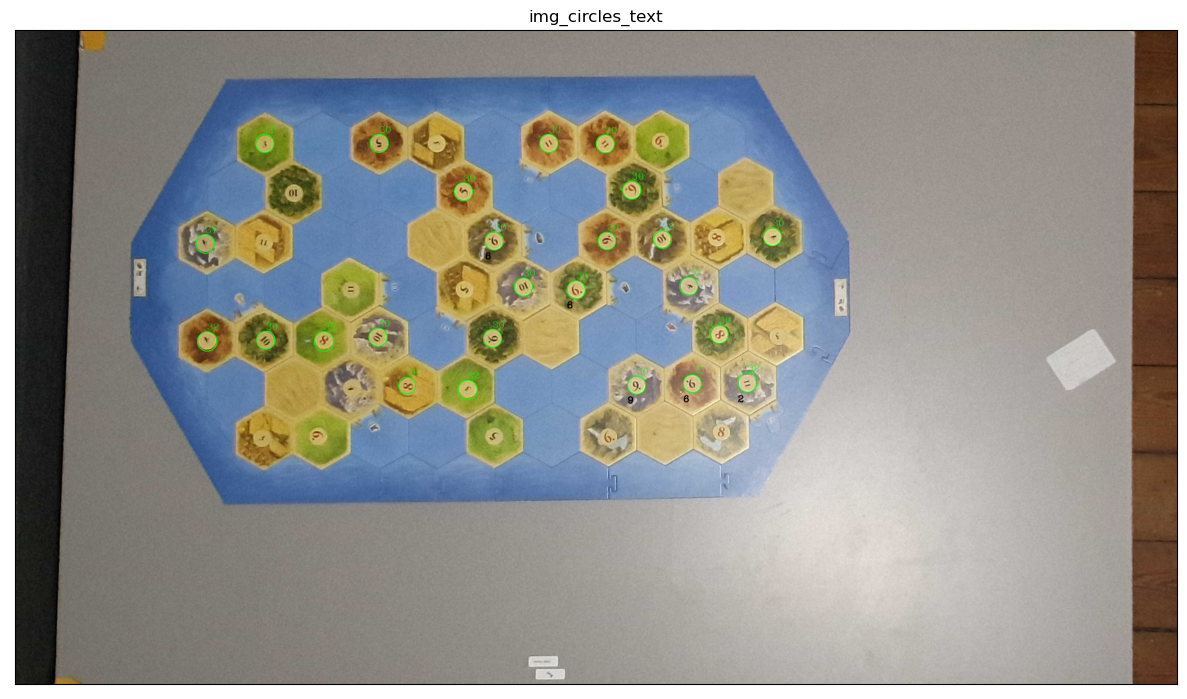

In [ ]:
import pytesseract  
# get the img content of the first cirlce and print it
circleIndex=0
def getTextForCircle(x, y, r):
    global circleIndex
    #crop the image
    crop_img = img[y-r:y+r, x-r:x+r]
    #invert the colors 
    crop_img = cv2.bitwise_not(crop_img)
    #areplace everything thats outside the circle with the color white
    mask = np.zeros(crop_img.shape[:2], dtype="uint8")
    cv2.circle(mask, (r, r), r-3, 255, -1)
    crop_img = cv2.bitwise_and(crop_img, crop_img, mask=mask)
    crop_img = cv2.bitwise_not(crop_img)

    
    #print it
    #make it grey
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
    #normalize it
    crop_img = cv2.normalize(crop_img, None, 0, 255, cv2.NORM_MINMAX)
    #threshold img at 160
    crop_img = cv2.threshold(crop_img, 140, 255, cv2.THRESH_BINARY)[1]
    if (debug): show_rgb_image(crop_img, 'crop_img', 1)
    #detect the number in it using ocr
    #configure tesseract for reading numbers, also make it expect onyl one big number in the image
    custom_config = r'--psm 10 --oem 3 -c tessedit_char_whitelist=12345689'
    text = pytesseract.image_to_string(crop_img, config=custom_config)

    #print the img
    #show_rgb_image(crop_img, 'crop_img: '+text, 1)
    #save the img in circles folder
    cv2.imwrite('./circles/img_'+name+'_'+str(circleIndex)+'.png', crop_img)
    circleIndex += 1

    #remove all non digit characters
    return ''.join(filter(str.isdigit, text))

# copy img_circles to img_circles_text
img_circles_text = img_circles.copy()

#find the text for all circles and print in the circles in the imag
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        text = getTextForCircle(i[0], i[1], i[2])
        cv2.putText(img_circles_text, text,
                    (i[0]-i[2], i[1]+2*i[2]), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,0), 2)

#print the image
show_rgb_image(img_circles_text, 'img_circles_text')

